# Gradient Boosting using LS Boost

The point of this workbook is to create some fake data, then solve for the class using Gradient Boosting and specifically the LS Boost algorithm.

None of the code here is taken from the Coursera course.  This exercise is actually not related to the Coursera Machine Learning Specialization, and instead works off the following resources:

https://web.stanford.edu/~hastie/Papers/ESLII.pdf <br>
http://statweb.stanford.edu/~jhf/ftp/trebst.pdf <br>
https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d <br>
https://www.youtube.com/watch?time_continue=562&v=sRktKszFmSk <br>

For this workbook we're leaning hard on different Python packages.  For fitting our trees we're using scikit learn.

We'll be focusing on the LS Boost algorithm because it's easier to interpret and the same ideas and methods can be extended to more advanced algorithms.  We can find the algorithm in "Greedy Function Approximation: A Gradient Boosting Machine" which looks like the following:
<img src="https://github.com/yeamusic21/Coursera-Machine-Learning-Specialization-Extra-Assignments/blob/master/Classification/img/ls_boost_algorithm.PNG?raw=true">

## Create Some Fake Data to Fit

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

So the idea here is to create some kind of data with a bit of structure and noise and then create a decision boundry to create our dependent variable.  The creation for X1 and X2, our independent variables don't necesarrily make a lot of sense, I'm just basically playing around to create some fake data to model.

In [4]:
#### CREATE FAKE DATA

# simulate some data
column1 = np.repeat(1, 100)
column2 = np.arange(-5,5,.1)
column3 = (column2**2)/1
column4 = (column2**3)/10
column5 = (column2**4)/100
Xplay = np.matrix([column1,column2,column3,column4,column5])
Xplay = Xplay.transpose()
# save column1 from Xplay as our first modeling variable
X1 = Xplay[:,1]
# make up some parameters
B = np.matrix(np.array([5.0345,2.0961,2.5109,1.0432,3.6657]))
B = B.transpose()
# create some fake noise
e = np.matrix(np.random.normal(0, 19, 100))
e = e.transpose()
# finally, create another fake variable using an arbitrary function with noise
X2 = Xplay*B + e

# now we're going to set some arbitrary line to pick our 1's and 0's
# and we'll add some noise so it's not perfectly linearly separable
bound = np.arange(min(X2),max(X2),(max(X2)-min(X2))/len(X2))
Y = []
for i in range(100):
    if X2[i] + np.random.normal(0, 40, 1) > bound[i]:
        Y.append(1)
    else:
        Y.append(0)

# reformat Y
Y = np.matrix([Y])
Y = Y.transpose()

Now lets take a look at the data we created and that we're going to try and model

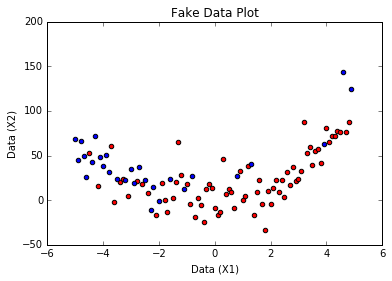

In [6]:
# plot our fake data to make sure it looks as we would expect

mask1 = Y!=1
mask0 = Y!=0

X1f = X1.flatten()
X2f = X2.flatten()

intercept = np.matrix(np.repeat(1, 100))
X = np.concatenate((intercept.transpose(),X1,X2),axis=1)

plt.scatter(X1f[mask1.ravel()], X2f[mask1.ravel()],c='red')
plt.scatter(X1f[mask0.ravel()], X2f[mask0.ravel()],c='blue')
plt.title('Fake Data Plot')
plt.xlabel("Data (X1)")
plt.ylabel("Data (X2)")
plt.show()

### Fit Gradient Boosting using Regression Tree as Base Learner 

I wanted to use dynamic variables, but I had a bit of trouble.  I used the following article as a reference.

*Resource or creating dynamic variables:* http://stupidpythonideas.blogspot.com/2013/05/why-you-dont-want-to-dynamically-create.html

But when I set everything up, every model just returned the predictions of the final model.  Not sure why it was giving me trouble (not the 1st time with Python) so instead I just dropped the dynamic variables and scored the data as I was training.

Another thing to notice is that we're using a regression tree for classification.  So we start off with the mean being our initial prediction (something like 0.28) and then from there our regression tree will work to separate the 1's from the 0's, and this works great, as we will see.

In [7]:
# imports
import time
from sklearn.tree import DecisionTreeRegressor

In [67]:
# create function that will compute the initial pseudo residuals
def get_initial_pseudo_residuals(target):
    avg = sum(target)/float(len(target))
    avg = np.repeat(avg,len(target))
    avg = avg.transpose()
    pseudo_residuals = Y - avg
    return pseudo_residuals

In [68]:
# create function that will return the predictions from the initial learner
def get_initial_predictions(target):
    avg = sum(target)/float(len(target))
    avg = np.repeat(avg,len(target))
    avg = avg.transpose()
    return avg

In [84]:
# set some of the hyperparameters
rounds = 3000
mydepth = 3
learning_rate = 0.01

# define training data
X = np.concatenate((X1,X2),axis=1)

# define classifier as classification tree with set depth
clf = DecisionTreeRegressor(max_depth=mydepth)

# initial error history for plotting later
error_history = []

# Train Gradient Boosting
for i in range(rounds):
    if i==0:
        # calculate initial pseudo residuals
        pseudo_residuals = get_initial_pseudo_residuals(target=Y)
        # calculate final predictions as we train
        predicted = get_initial_predictions(target=Y)
    else:
        # fit model on the pseudo residuals
        model = clf.fit(X,pseudo_residuals)
        # calculate predictions
        predictions = model.predict(X)
        # transpose predictions for next step
        predictions = np.matrix(predictions).transpose()
        # update pseudo residuals
        pseudo_residuals = pseudo_residuals - learning_rate*predictions
        # calculate final predictions as we train
        predicted = predicted + learning_rate*predictions
        # save binary error for plotting later on
        error_history.append(sum(abs(Y - predicted)).item(0))

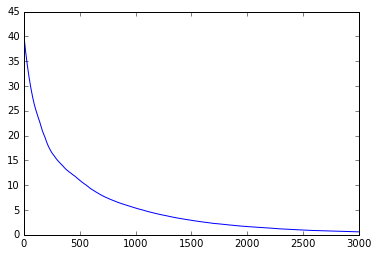

In [85]:
# plot error history
x = np.arange(0,rounds-1,1)
plt.plot(x,error_history)

So you can see that we followed the algorithm pretty well and our error goes to 0 on training, so it looks like we coded it correctly.  Pretty cool!  Lets see how our final plot looks...

In [90]:
# determine final predictions from scores
predictions = []
for k in range(len(X)):
    if predicted[k].item(0)>0.5:
        predictions.append(1)
    else:
        predictions.append(0)

Now let's plot our results!

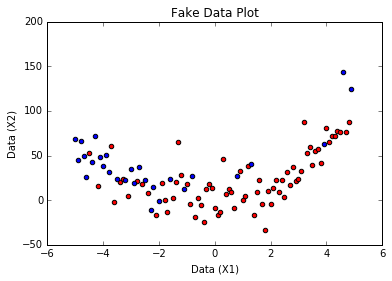

Accuracy: 1.0


In [91]:
#### PLOT ADABOOST RESULTS

# training data
X = np.concatenate((X1,X2),axis=1)

# get predicted
predicted = predictions
predicted = np.matrix(predicted).transpose()

# compute masks for plotting
mask1 = predicted!=1
mask0 = predicted!=0

# reformat for plotting
X1f = X[:,0].flatten()
X2f = X[:,1].flatten()

# plot results
plt.scatter(X1f[mask1.ravel()], X2f[mask1.ravel()],c='red')
plt.scatter(X1f[mask0.ravel()], X2f[mask0.ravel()],c='blue')
plt.title('Fake Data Plot')
plt.xlabel("Data (X1)")
plt.ylabel("Data (X2)")
plt.show()

# compute and print accuracy
correct = 0
for i in range(len(Y)):
    if Y[i,]==predicted[i,]:
        correct += 1
print "Accuracy:",correct / float(len(Y))

WOW!  100% on training!  That's pretty awesome that we did it!  Obviously we don't know how it generalizes (probably not well because we're clearly overfitting), but this was not in scope for this workbook.  The main thing I wanted to do was code it up from scratch and show it working properly, which we did!  Hooray! 